In [11]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Functions

In [12]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [13]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

### Data cleaning, feature building

In [14]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [15]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Performing a log transformation on lot area helps make this distribution look more normal. Let's run with that.

In [16]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

In [17]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})

In [18]:
# Interesting variables we can try plotting against sale price
vars_of_interest = ['saleprice','log_lotarea','neighborhood','bldgtype','housestyle','yearbuilt',
                    'grlivarea','garagearea','has_deck','has_porch','mosold']

In [19]:
# Start with these features of interest. 
vars_of_interest = ['saleprice','log_lotarea','neighborhood','bldgtype','housestyle','yearbuilt',
                    'grlivarea','garagearea','has_deck','has_porch']

house_interest_df = house_df[vars_of_interest]
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,grlivarea,garagearea,has_deck,has_porch
0,208500,9.041922,CollgCr,1Fam,2Story,2003,1710,548,0,1
1,181500,9.169518,Veenker,1Fam,1Story,1976,1262,460,1,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1786,608,0,1
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1717,642,0,1
4,250000,9.565214,NoRidge,1Fam,2Story,2000,2198,836,1,1


In [20]:
# Append one-hot versions of neighborhoods and house style to the dataframe of interesting variables
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['neighborhood'],drop_first=True)], axis=1)
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['housestyle'],drop_first=True)], axis=1)
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,grlivarea,garagearea,has_deck,has_porch,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
0,208500,9.041922,CollgCr,1Fam,2Story,2003,1710,548,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,181500,9.169518,Veenker,1Fam,1Story,1976,1262,460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1786,608,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1717,642,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,250000,9.565214,NoRidge,1Fam,2Story,2000,2198,836,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Run your house prices model again and interpret the results. Which features are statistically significant, and which are not?

In [21]:
hidf_features = ['log_lotarea','yearbuilt','grlivarea','garagearea','has_deck','has_porch',
                  'Blueste','BrDale','BrkSide','ClearCr','CollgCr','Crawfor','Edwards','Gilbert','IDOTRR',
                  'MeadowV','Mitchel','NAmes','NPkVill','NWAmes','NoRidge','NridgHt','OldTown','SWISU','Sawyer',
                  'SawyerW','Somerst','StoneBr','Timber','Veenker','1.5Unf','1Story','2.5Fin','2.5Unf','2Story',
                  'SFoyer','SLvl']

In [22]:
# Y is the target variable
Y = house_interest_df['saleprice']
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 2.27692806e+04  5.99704861e+02  7.42977651e+01  3.29664365e+01
  7.55276352e+03  7.89049238e+03  6.53655299e+03  2.94547846e+03
 -3.12273967e+03 -1.30002444e+04 -1.02629464e+04  2.20118732e+04
 -3.47393586e+04 -1.97126997e+04 -2.36636074e+04 -1.94303280e+04
 -3.19430597e+04 -2.40826762e+04  2.61315395e+02 -2.53734412e+04
  4.70241730e+04  6.03769010e+04 -1.76208292e+04 -2.06312258e+04
 -2.93319364e+04 -2.26164512e+04  1.34616230e+04  6.80099501e+04
  2.58344785e+03  2.08479181e+04  2.35237122e+04  1.56768030e+04
 -1.59092892e+04 -1.83376724e+03 -5.31771554e+03  2.62657827e+04
  1.27852615e+04]

Intercept: 
 -1345087.0628465407


In [23]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     147.0
Date:                Fri, 26 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:15:30   Log-Likelihood:                -17395.
No. Observations:                1460   AIC:                         3.487e+04
Df Residuals:                    1422   BIC:                         3.507e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.345e+06   1.52e+05     -8.825      0.000   -1.64e+06   -1.05e+06
log_lotarea  2.277e+04   2894.075      7.868      0.000    1.71e+04    2.84e+04
yearbuilt     599.7049     73.491      8.160      0.000     455.542     743.867
grlivarea      74.2978      3.112     23.877      0.000      68.194      80.402
garagearea     32.9664      6.288      5.243      0.000      20.632      45.301
has_deck     7552.7635   2104.872      3.588      0.000    3423.776    1.17e+04
has_porch    7890.4924   2264.378      3.485      0.001    3448.612    1.23e+04
Blueste      6536.5530   2.77e+04      0.236      0.814   -4.78e+04    6.09e+04
BrDale       2945.4785   1.35e+04      0.219      0.827   -2.35e+04    2.93e+04
BrkSide     -3122.7397   1.16e+04     -0.270      0.787   -2.58e+04    1.96e+04
ClearCr       -1.3e+04   1.25e+04     -1.040      0.298   -3.75e+04    1.15e+04
CollgCr     -1.026e+04   9940.755     -1.032      0.302   -2.98e+04    9237.173
Crawfor      2.201e+04   1.15e+04      1.908      0.057    -622.116    4.46e+04
Edwards     -3.474e+04   1.06e+04     -3.270      0.001   -5.56e+04   -1.39e+04
Gilbert     -1.971e+04   1.07e+04     -1.846      0.065   -4.07e+04    1237.261
IDOTRR      -2.366e+04   1.23e+04     -1.929      0.054   -4.77e+04     403.701
MeadowV     -1.943e+04   1.32e+04     -1.474      0.141   -4.53e+04    6426.544
Mitchel     -3.194e+04    1.1e+04     -2.896      0.004   -5.36e+04   -1.03e+04
NAmes       -2.408e+04   1.02e+04     -2.356      0.019   -4.41e+04   -4030.280
NPkVill       261.3154   1.54e+04      0.017      0.986   -2.99e+04    3.04e+04
NWAmes      -2.537e+04   1.07e+04     -2.377      0.018   -4.63e+04   -4437.798
NoRidge      4.702e+04   1.13e+04      4.152      0.000    2.48e+04    6.92e+04
NridgHt      6.038e+04   1.03e+04      5.865      0.000    4.02e+04    8.06e+04
OldTown     -1.762e+04   1.13e+04     -1.564      0.118   -3.97e+04    4483.542
SWISU       -2.063e+04   1.31e+04     -1.576      0.115   -4.63e+04    5055.877
Sawyer      -2.933e+04   1.08e+04     -2.717      0.007   -5.05e+04   -8154.790
SawyerW     -2.262e+04   1.07e+04     -2.121      0.034   -4.35e+04   -1700.643
Somerst      1.346e+04   1.02e+04      1.323      0.186   -6502.328    3.34e+04
StoneBr      6.801e+04   1.18e+04      5.768      0.000    4.49e+04    9.11e+04
Timber       2583.4478   1.15e+04      0.225      0.822      -2e+04    2.51e+04
Veenker      2.085e+04   1.48e+04      1.412      0.158   -8107.002    4.98e+04
1.5Unf       2.352e+04   1.05e+04      2.242      0.025    2937.431    4.41e+04
1Story       1.568e+04   3930.604      3.988      0.000    7966.399    2.34e+04
2.5Fin      -1.591e+04   1.42e+04     -1.118      0.264   -4.38e+04     1.2e+04
2.5Unf      -1833.7672   1.17e+04     -0.157      0.876   -2.48e+04    2.11e+04
2Story      -5317.7155   3963.188     -1.34

__Note: I already did this step in an earlier exercise. I'm just leaving the work I did here, because it's exactly what I'm being asked to do for this assignment. I guess I got ahead of myself!__

## Now, exclude the insignificant features from your model. Did anything change?

__Features with a high p-value, that we can drop:__
* Neighborhood dummies:
	* Blueste
	* BrDale
	* BrkSide
	* Clearcr
	* CollgCr
	* Crawfor
	* Gilbert
	* IDOTRR
	* MeadowV
	* NPkVill
	* OldTown
	* SWISU
	* Somerst
	* Timber
	* Veenker
* House style:
	* 2.5Fin
	* 2.5Unf
	* 2Story


In [24]:
hidf_features = ['log_lotarea','yearbuilt','grlivarea','garagearea','has_deck','has_porch',
                  'Edwards',
                  'Mitchel','NAmes','NWAmes','NoRidge','NridgHt','Sawyer',
                  'SawyerW','StoneBr','1.5Unf','1Story',
                  'SFoyer','SLvl']

In [25]:
# Y is the target variable
Y = house_interest_df['saleprice']
# X is the feature set. I hope I didn't choose too many features...?
X = house_interest_df[hidf_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 2.12134602e+04  6.47107175e+02  7.64481727e+01  3.82876224e+01
  5.61032638e+03  7.21251314e+03 -2.63043990e+04 -2.55744339e+04
 -1.74271882e+04 -2.03593305e+04  4.98358008e+04  6.25402549e+04
 -2.20861892e+04 -1.76178766e+04  7.09796734e+04  3.08195714e+04
  2.19459990e+04  2.83208197e+04  1.71818992e+04]

Intercept: 
 -1439981.7475539038


In [26]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 26 Jul 2019   Prob (F-statistic):               0.00
Time:                        14:21:31   Log-Likelihood:                -17444.
No. Observations:                1460   AIC:                         3.493e+04
Df Residuals:                    1440   BIC:                         3.503e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.44e+06   8.49e+04    -16.961      0.000   -1.61e+06   -1.27e+06
log_lotarea  2.121e+04   2290.103      9.263      0.000    1.67e+04    2.57e+04
yearbuilt     647.1072     41.082     15.752      0.000     566.520     727.694
grlivarea      76.4482      2.976     25.693      0.000      70.611      82.285
garagearea     38.2876      6.226      6.149      0.000      26.074      50.501
has_deck     5610.3264   2122.888      2.643      0.008    1446.042    9774.611
has_porch    7212.5131   2282.772      3.160      0.002    2734.598    1.17e+04
Edwards      -2.63e+04   4147.841     -6.342      0.000   -3.44e+04   -1.82e+04
Mitchel     -2.557e+04   5712.614     -4.477      0.000   -3.68e+04   -1.44e+04
NAmes       -1.743e+04   3104.306     -5.614      0.000   -2.35e+04   -1.13e+04
NWAmes      -2.036e+04   4721.335     -4.312      0.000   -2.96e+04   -1.11e+04
NoRidge      4.984e+04   6458.285      7.717      0.000    3.72e+04    6.25e+04
NridgHt      6.254e+04   4872.416     12.836      0.000     5.3e+04    7.21e+04
Sawyer      -2.209e+04   4786.140     -4.615      0.000   -3.15e+04   -1.27e+04
SawyerW     -1.762e+04   5166.294     -3.410      0.001   -2.78e+04   -7483.608
StoneBr      7.098e+04   7837.796      9.056      0.000    5.56e+04    8.64e+04
1.5Unf       3.082e+04   1.04e+04      2.950      0.003    1.03e+04    5.13e+04
1Story       2.195e+04   2695.671      8.141      0.000    1.67e+04    2.72e+04
SFoyer       2.832e+04   6864.059      4.126      0.000    1.49e+04    4.18e+04
SLvl         1.718e+04   5256.132      3.269      0.001    6871.403    2.75e+04
==============================================================================
Omnibus:                      353.261   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18786.934
Skew:                           0.056   Prob(JB):                         0.00
Kurtosis:                      20.573   Cond. No.                     2.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared value suggests our model can explain 77.8% of the data. The adjusted R-squared value is nearly the same (77.5%), so we aren't being penalized for redundant features. 

The F-statistic is a lot higher than the first run.

The p-values of the remaining features are all close to zero, showing that they have significance in this iteration of the model.

## Interpret the statistically significant coefficients by quantifying their relations with the house prices. Which features have a more prominent effect on house prices?

### Do the results sound reasonable to you? If not, try to explain the potential reasons.

Having a porch adds an average of \\$7,212.51 to the sale price of the home, and having a deck adds \\$5,610.33 on average.

The style of home also has some influence--some of the home style dummy variables were dropped as insignificant, but of those that remain:
* A 1.5-story home with an unfinished upper level sees a bump of about \$30,820.
* A 1-story home increases the price by \$21,950. (The bump for varying styles of 1- and 1.5-story homes seemed odd at first, but maybe 1-story homes have more appeal because they are more accessible? I also wonder if 1-story homes also make up for not having multiple levels by sprawling a bit more, on a larger lot. These could be additional research topics for later.)
* A split foyer sees an average bump of \$28,320.
* A split-level home sees an average bump of \$17,180.

The amount of above-ground living space, and the size of the garage, also contribute. For each additional square foot of above-ground living space, the home price increases \\$76.45 on average, and each additional square foot of garage space adds \\$38.29.

Newer homes have a small advantage--for each successive year, the home price increases by an average of $647.11.

We dropped a lot of neighborhood dummy features, but those that remain have significance. It's interesting that some neighborhoods add to home price, and some contribute to a _lower_ home price. Further research would be to map out these neighborhoods and see how they relate to each other geographically, and to the city's destinations and amenities.

Neighborhoods that are positive contributors to sale price:
* Northridge (+\$49,840)
* Northridge Heights (+\$62,540)
* Stone Brook (+\$70,980)

Neighborhoods that are detractors from sale price:
* Edwards (-\$26,300)
* Mitchell (-\$25,570)
* North Ames (-\$17,430)
* Northwest Ames (-\$20,360)
* Sawyer (-\$22,090)
* Sawyer West (-\$17,620)

One last contributor is the lot area. A log-transformed version of lot area was used here because its distribution was closer to normal than the distribution of lot area...but that log transformation makes the coefficient harder to interpret.

I found [a helpful explanation of how to handle log-transformed variables in a linear regression model](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/). For an independent variable, it suggests:

> Divide the coefficient by 100. This tells us that a 1% increase in the independent variable increases (or decreases) the dependent variable by (coefficient/100) units. Example: the coefficient is 0.198. 0.198/100 = 0.00198. For every 1% increase in the independent variable, our dependent variable increases by about 0.002. For x percent increase, multiply the coefficient by log(1.x). Example: For every 10% increase in the independent variable, our dependent variable increases by about 0.198 * log(1.10) = 0.02.

The coefficient for the log-lot area is 21,210. Divided by 100, we get 212.10. So, for every 1% increase in lot area, the home price increases by an average of \\$212.10.

Lot area varies between 1300 sq. ft. and 215,245 sq. ft. There are four really large lots in our sample that are over 100,000 sq. ft--all of the other lots are under about 70,000 sq. ft, with a mean of around 10,500 sq. ft.

So, would we calculate percentage using the largest lot size as the denominator? For example:

In [41]:
house_df.loc[345,['lotarea','log_lotarea','grlivarea']]

lotarea        2592   
log_lotarea    7.86019
grlivarea      1112   
Name: 345, dtype: object

In [46]:
2592 / 215245 * 100

1.2042091570071314

This lot size is only 1.204% of the largest lot, so the price bump would be 1.204 times 212.10, or \\$255...?

In [50]:
212.10 * 1.2042091570071314

255.41276220121256

In [35]:
house_df["lotarea"].describe()

count    1460.000000  
mean     10516.828082 
std      9981.264932  
min      1300.000000  
25%      7553.500000  
50%      9478.500000  
75%      11601.500000 
max      215245.000000
Name: lotarea, dtype: float64

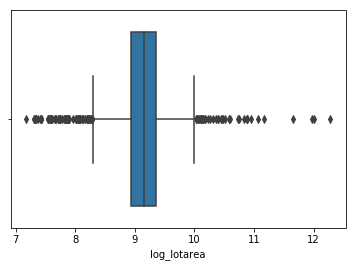

In [37]:
sns.boxplot(house_df['log_lotarea'])

In [27]:
house_df["log_lotarea"].describe()

count    1460.000000
mean     9.110838   
std      0.517448   
min      7.170120   
25%      8.929766   
50%      9.156781   
75%      9.358890   
max      12.279532  
Name: log_lotarea, dtype: float64